# Reality 1: Spherical NFW halos and de Vaucouleurs bulges

## 1. The mock sample

An ensemble of time-delay lenses is generated as follows. We draw halo masses from a Gaussian distribution: $\log{M_h} \sim \mathcal{N}(\mu_h, \sigma_h)$

For each halo, we draw a stellar mass from a Gaussian distribution with mean that depends with halo mass: $\log{M_*} \sim \mathcal{N}(\mu_* + \beta(\log{M_h} - 13), \sigma_*)$. In other terms, halo and stellar masses are drawn from a multivariate Gaussian

$\rm{Pr}(\log{M_h}, \log{M_*}) = \frac{1}{2\pi|C|^{1/2}}\exp{\left\{ - \frac12(\vec{m} - \vec{\mu})^\intercal C^{-1} (\vec{m} - \vec{\mu})\right\}}$

with $\vec{m} = (\log{M_h}, \log{M_*})$, $\vec{\mu} = (\mu_h, \mu_* + \beta(\mu_h - 13))$ and $C = \left(\begin{array}{cc} \sigma_h^2 & \beta\sigma_h^2\\ \beta\sigma_h^2 & \sigma_*^2 + \beta^2\sigma_h^2\end{array}\right)$

The redshift of each object is drawn from a uniform distribution between $z_{d,min} = 0.1$ and $z_{d,max} = 0.3$.

The halo mass is defined as the mass of the sphere with mean density equal to $\Delta = 93.5$ times the critical density of the Universe at its redshift. Each halo is assigned a concentration given by the mass-concentration relation from Macci\`{o} et al. (2008):

$log{c_{vir}} = 0.971 - 0.094(\log{M_h} - 12)$

with no scatter (halo mass unequivocally defines concentration).

The projected distribution of stars is described by a de Vaucouleurs profile. The effective radius of this profile is drawn from a Gaussian with mean that scales with stellar mass and redshift, following Newman et al. (2012):

$\log{R_e} \sim \mathcal{N}(\mu_R + \zeta_R(z - 0.7) + \beta_R(\log{M_*} - 11)$, \sigma_R)$

with $\mu_R = 0.46$, $\zeta_R = 0.26$, $\beta_R = 0.59$.

At this point the mass distribution of each system is well-defined. 
Then we add a background source to each lens. The source redshift is drawn from an exponential distribution in $\log{z_s}$:

${\rm Pr}(z_s) \propto \exp{\left\{-[\log{(z_s - 0.4)}]^2\right\}}$

truncated at $z_{s,min}=0.4$ and $z_{s,max}=4$.

For each lens we calculate the position of the radial caustic and then draw the source position from a uniform distribution within the circle of radius given by the caustic. We solve the lens equation and calculate image positions and time-delay between the two images.

We also assign a stellar IMF mismatch parameter $\alpha_{\mathrm{IMF}}$ to each galaxy, drawn from a Gaussian in $\log{\alpha_{\mathrm{IMF}}}$ with mean 0 (corresponding to a Salpeter IMF) and dispersion $\sigma_{\mathrm{IMF}}$.
Given $M_*$ and $\alpha_{\mathrm{IMF}}$ we can calculate the "Salpeter stellar mass", $M_*^{\mathrm{(Salp)}}$ that is the stellar mass one would infer assuming a Salpeter IMF and having an otherwise perfect knowledge of the stellar population parameters (whatever that means..).

These are the observables:

Observable                           | Uncertainty
-------------------------------------|-------------
$z_d$                                |known exactly
$z_s$                                |known exactly
Image positions $(\theta_A, \theta_B)$| 0.1arcsec
Time delay $\Delta t$                |5 day
$M_*^{\mathrm{(Salp)}}$               |0.1 dex
$R_e$                                | known exactly



In [3]:
# from toy_models import sample_generator

# mock = sample_generator.simple_reality_sample_nocvirscat(nlens=100)

## 2. The model

The model we are using to fit the mock data is exactly the same used to generate it.

## 3. The fit

We first fit image positions and Salpeter stellar masses for each object separately. We make MCMC chains in $\log{M_*^}$, $\log{M_h}$, $\alpha_{\mathrm{IMF}}$ and for each point in the chain we calculate the predicted time delay assuming a Hubble constant of 70 km s$^{-1}$.
To save time we can thin the individual lenses' chains by a factor of 10.

In [12]:
# import lens_samplers

# chains = []

# for lens in mock['lenses']:
#     chain = lens_samplers.fit_nfwdev_nocvirscat_noradmagfit_nodtfit(lens, nstep=15000, burnin=5000, thin=10)
#     chains.append(chain)

Then we run the hierarchical inference code. At each step, given the values of the hyperparameters, we calculate the integrals over the individual halo mass, stellar mass and IMF parameter by Monte Carlo integration over the samples previously obtained, weighted by 1) the new priors on stellar, halo mass and IMF specified by the hyperparameters and 2) the likelihood of the observed time-delay given the value of H0.

In [8]:
# from toy_models import hierarchical_inference as hi

# chain = hi.infer_simple_reality(mock['truth'], chains, nstep=50000, burnin=10000)

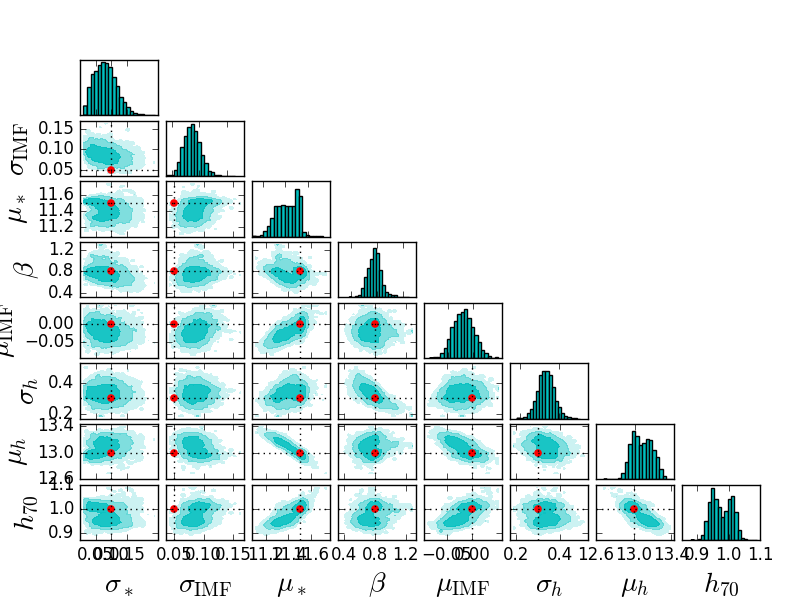

In [10]:
from IPython.display import Image
Image(filename="../allZeTests/simple_reality_mockD_100lenses_cp.png")

We seem to recover most of the parameters, including $h_{70}$. The only parameter that is off is the scatter in the IMF normalization.

## 4. Some tests

### 4.1 Increasing the number of samples in the importance sampling chain

The above cornerplot was produced by doing the individual lens parameters integrals with samples of 1000 points, obtained by thinning chains that were 10x longer. What happens if we just use the whole 10^4 points chain?

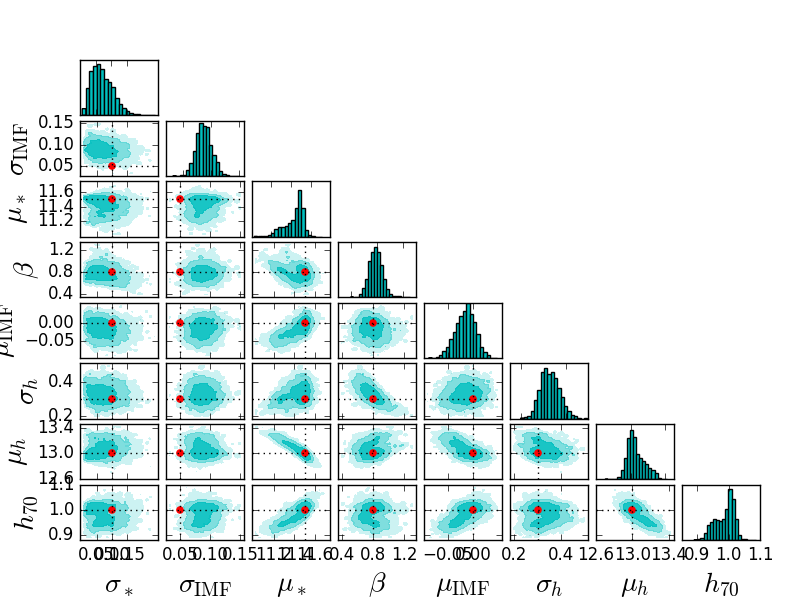

In [11]:
from IPython.display import Image
Image(filename="../allZeTests/simple_reality_mockD_100lenses_nothin_cp.png")

Nothing changes.

### 4.2 Increasing the length of the chains during the sampling of the individual interim posteriors

What happens if we run longer chains for the sampling of the individual interim posteriors? The individual chains themselves look very similar to these shorter ones, but the hierarchical inference...

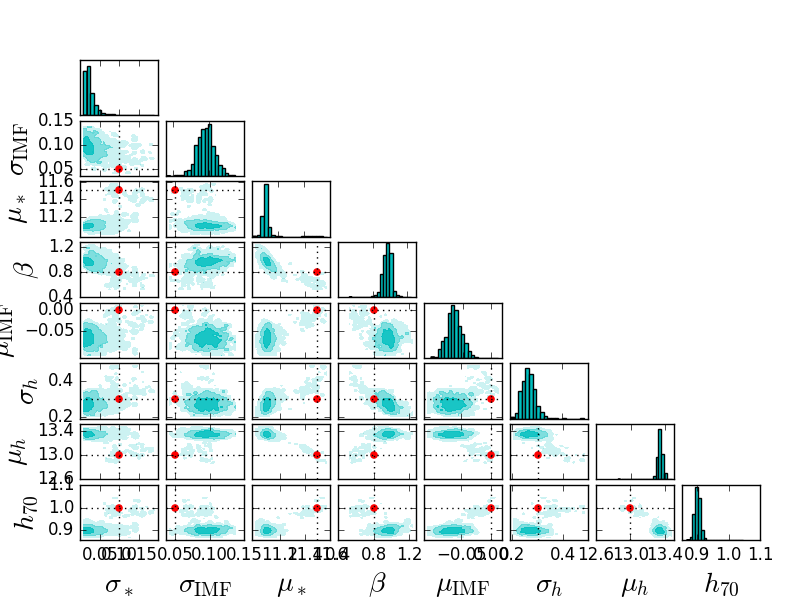

In [2]:
from IPython.display import Image
Image(filename="../allZeTests/simple_reality_mockD_100lenses_Nind1e5_cp.png")

is completely screwed up.

## 5. Interim priors to the rescue

Let's look at one lens and its individual posterior obtained assuming flat priors on stellar and halo mass.

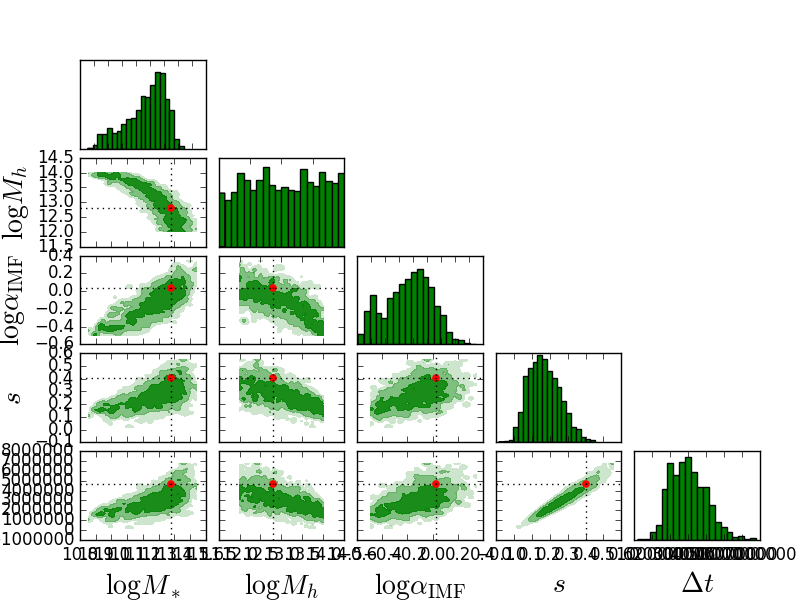

In [5]:
from IPython.display import Image
Image(filename="../allZeTests/simple_reality_100lenses_mstarmhaloprior_lens00_wflatprior.png")

Looking at the stellar mass vs. halo mass panel, we see that most points corresponds to models with either a very large stellar mass and no dark matter or with a very large dark matter mass and no stars.
Most samples cover a region of the parameter space that is irrelevant, and possibly that's what is throwing off the hierarchical inference fit.

Let's fix this by using a reasonable prior on the ratio between stellar and halo mass. For example let's use the following prior on the halo mass:

$\log{M_h} \sim \mathcal{N}(\log{M_*} + 1.7, 0.3)$

which means we believe the halo mass to be about a factor of 50 more massive than the stellar mass, with a dispersion of a factor of 2.

The new posterior for the same lens looks like this:

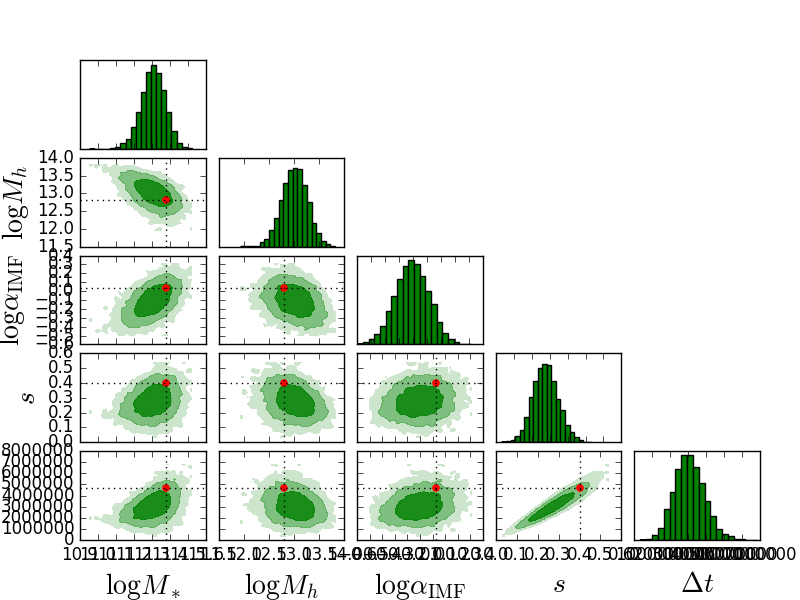

In [3]:
from IPython.display import Image
Image(filename="../allZeTests/simple_reality_100lenses_mstarmhaloprior_lens00.png")

Now we've eliminated the tails of ridiculous values of $(M_h, M_*)$.

Now we repeat the hierarchical inference, making sure to divide out this new interim prior when doing importance sampling.

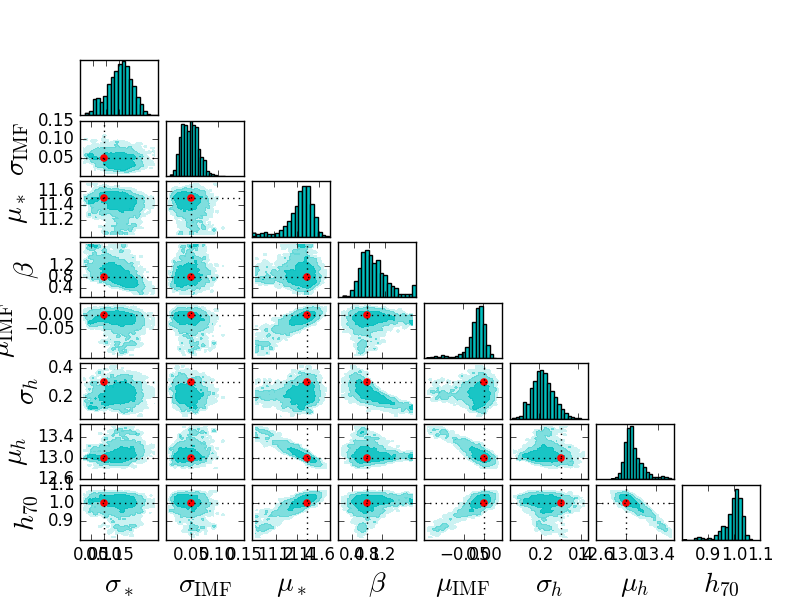

In [4]:
from IPython.display import Image
Image(filename="../allZeTests/simple_reality_100lenses_mstarmhaloprior_cp.png")

Granted that it's a different sample from the one used for the analysis shown in sections 3 and 4, but it seems to work!